In [142]:
# import Libraries
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [143]:
BASE_DIR = './tmp/data'
TRAIN_DIR = os.path.join(BASE_DIR, "train.csv")
TEST_DIR = os.path.join(BASE_DIR, "test.csv")

## Preprocessing

In [146]:
def wrangle(path):
    # read the dataframe
    df = pd.read_csv(path).set_index("PassengerId")
    
    # Drop columns that contain more than 50% NULL values and high-cardinality categorical features
    drop_cols = ["Name", "Ticket", "Cabin"]
    df.drop(columns=drop_cols, inplace=True)
    
    # Fill missing values with mostly repeated values
    df["Age"].fillna(df["Age"].median(), inplace=True)
    df["Embarked"].fillna("S", inplace=True)
    
    # Label Encoding
    cols = ["Sex", "Embarked"]
    encoder = LabelEncoder()
    for col in cols:
        df[col] = encoder.fit_transform(df[col])
    
    return df

In [145]:
df = wrangle(TRAIN_DIR)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [50]:
df.isnull().sum() 
# Drop columns that contain Null values more than 50%
# Impute missing value

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [51]:
df.nunique() # Drop high-cardinality categorical features

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

In [52]:
df["Embarked"].value_counts() # Filling the missing values with mostly repeated values which is "S"

S    644
C    168
Q     77
Name: Embarked, dtype: int64

###  Explore

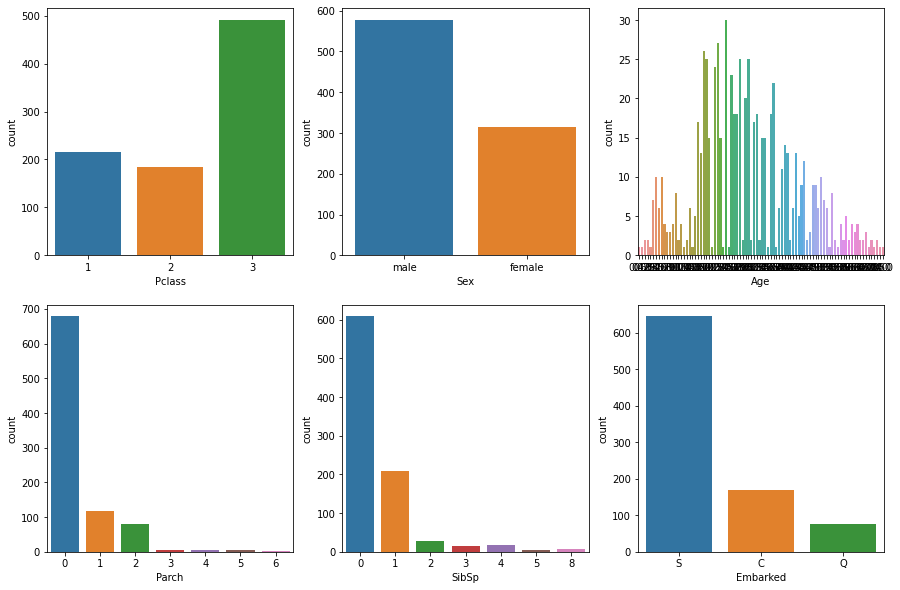

In [53]:
# get list of columns
columns =  ["Pclass", "Sex", "Age", "Parch", "SibSp", "Embarked"]

# Create the subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

# Flatten the axs array to simplify indexing
ax = ax.flatten()

# Loop through each column and plot it
for i, column in enumerate(columns):
    sns.countplot(x=column, data=df, ax=ax[i])

In [150]:
# grouped the age
df["Age"] = pd.cut(df["Age"], bins=5)

### Multicollinerity

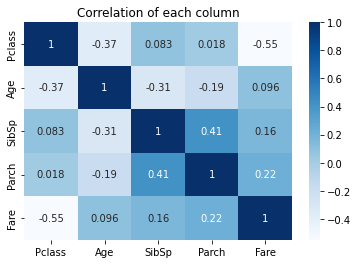

In [54]:
correlation = df.drop(columns="Survived").corr()
sns.heatmap(correlation, annot=True, cmap="Blues")
plt.title("Correlation of each column");

### Compare each columns with the target 

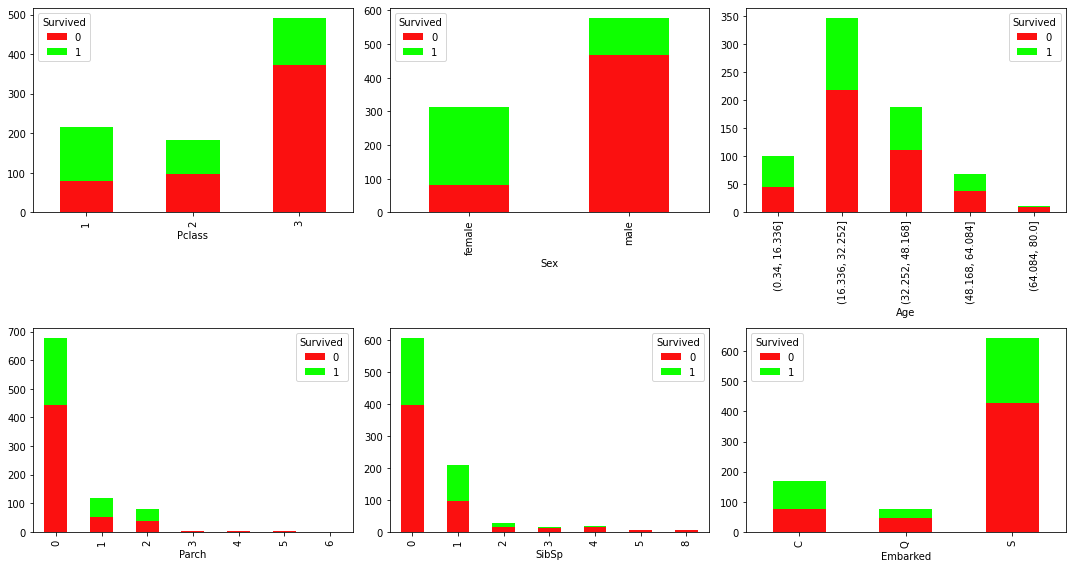

In [151]:
columns = ["Pclass", "Sex", "Age", "Parch", "SibSp", "Embarked"]

# create subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()

# Loop through each columns and plot it
for i, col in enumerate(columns):
    df.groupby([col, "Survived"]).size().unstack().plot(kind="bar", ax=ax[i], stacked=True, color=['#fb1010', '#0eff00'])

fig.tight_layout()

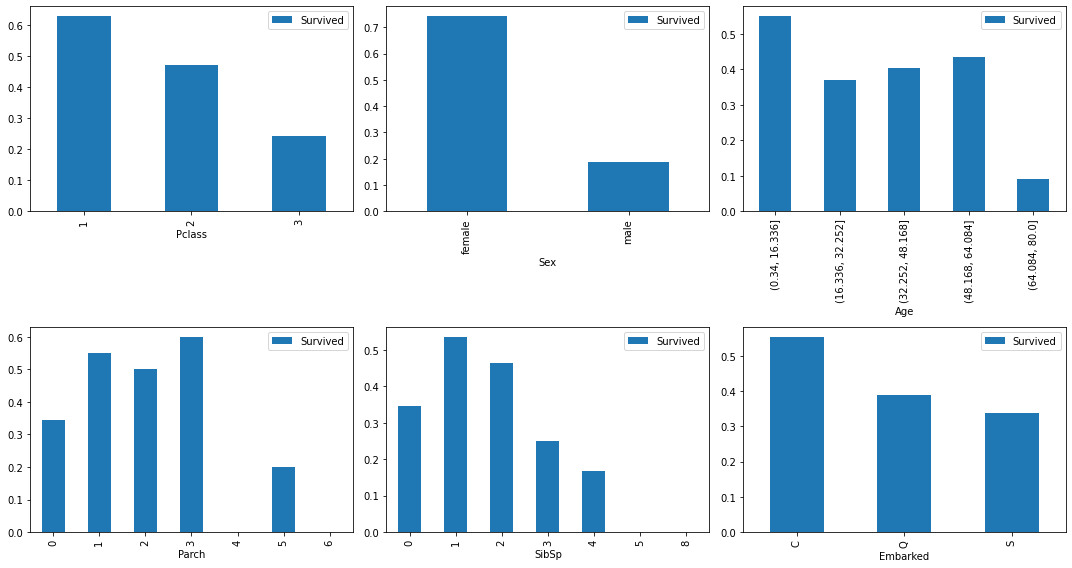

In [155]:
cols = ["Pclass", "Sex", "Age", "Parch", "SibSp", "Embarked"]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()

for i, col in enumerate(cols):
    pd.pivot_table(df, index=col, values="Survived", aggfunc=np.mean).plot(kind="bar", ax=ax[i])

fig.tight_layout()

In [5]:
train_df = wrangle(TRAIN_DIR)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,2
2,1,1,0,38.0,1,0,71.2833,0
3,1,3,0,26.0,0,0,7.9250,2
4,1,1,0,35.0,1,0,53.1000,2
5,0,3,1,35.0,0,0,8.0500,2


In [ ]:
# Label encoding for "Sex" and "Embarked"

## Split Data

In [87]:
# split the data into features and labels
target = "Survived"
X = train_df.drop(columns=target)
y = train_df[target]

# split the data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Model

In [134]:
# # sequential model
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

In [89]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 32)                256       
_________________________________________________________________
dense_30 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [135]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [137]:
# Train the model
history = model.fit(X_train,y_train,
                   epochs=20,
                   batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/20
72/72 [==============================] - 0s 5ms/step - loss: 0.4433 - accuracy: 0.8202 - val_loss: 0.4948 - val_accuracy: 0.7933
Epoch 2/20
72/72 [==============================] - 0s 3ms/step - loss: 0.4427 - accuracy: 0.8076 - val_loss: 0.4835 - val_accuracy: 0.7654
Epoch 3/20
72/72 [==============================] - 0s 3ms/step - loss: 0.4455 - accuracy: 0.8118 - val_loss: 0.4622 - val_accuracy: 0.7709
Epoch 4/20
72/72 [==============================] - 0s 3ms/step - loss: 0.4631 - accuracy: 0.8090 - val_loss: 0.4814 - val_accuracy: 0.7654
Epoch 5/20
72/72 [==============================] - 0s 3ms/step - loss: 0.4368 - accuracy: 0.8104 - val_loss: 0.4652 - val_accuracy: 0.7486
Epoch 6/20
72/72 [==============================] - 0s 3ms/step - loss: 0.4346 - accuracy: 0.8146 - val_loss: 0.4984 - val_accuracy: 0.7989
Epoch 7/20
72/72 [==============================] - 0s 3ms/step - loss: 0.4327 - accuracy: 0.8104 - val_loss: 0.4868 - val_accuracy: 0.7430
Epoch 8/20
72/72 [==

## Evaluate the results

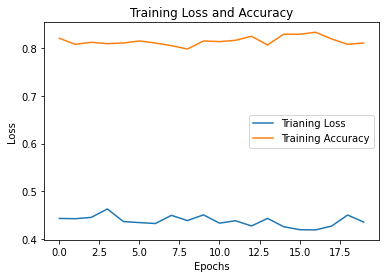

In [138]:
# plot training accuracy and loss
plt.plot(history.history['loss'],  label='Trianing Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

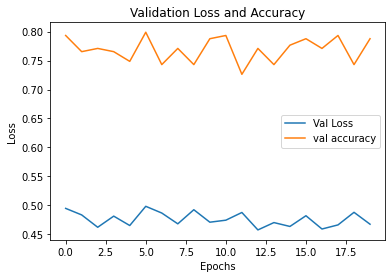

In [139]:
# Plot the validation accuracy and loss
plt.plot(history.history["val_loss"], label="Val Loss")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.title("Validation Loss and Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Save Model

In [210]:
# Save the model
model.save('./tmp/model/my_model.h5')

## Model Prediction

In [70]:
x_test = wrangle(TEST_DIR)
x_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,1,34.5,0,0,7.8292,1
893,3,0,47.0,1,0,7.0000,2
894,2,1,62.0,0,0,9.6875,1
895,3,1,27.0,0,0,8.6625,2
896,3,0,22.0,1,1,12.2875,2


In [266]:
y_pred = model.predict(x_test)
pred_df = pd.DataFrame(y_pred, columns=["Survived"]).set_index(x_test.index)
pred_df.head()

,Survived
PassengerId,
892,0.150513
893,0.305370
894,0.161322
895,0.159692
896,0.489967


In [274]:
# if y_pred > 0.5 -> Survived
# else -> "Died"
pred_df['Survived'] = pred_df["Survived"].apply(lambda x: 1 if x > 0.5 else 0)

### Submit

In [272]:
pred_df.to_csv("./tmp/data/submission.csv")